###### 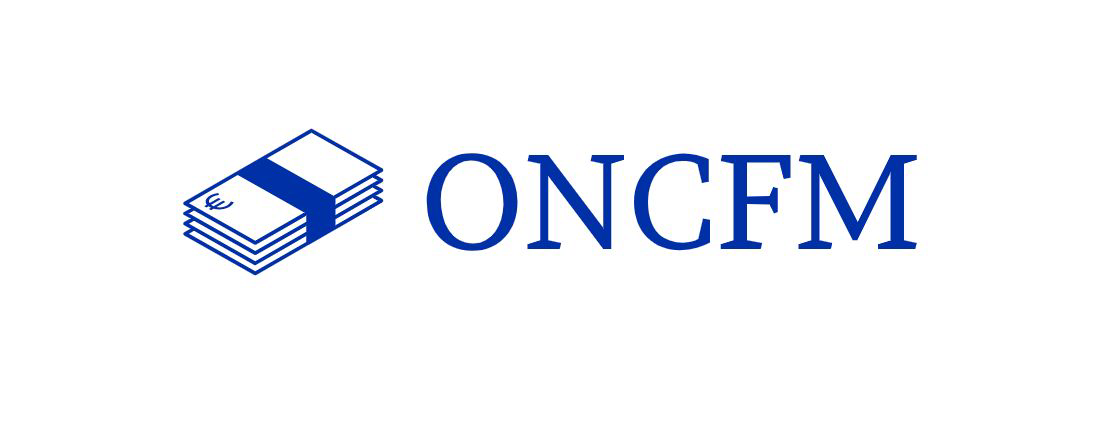

# PROJET 10: Détectez des faux billets avec R ou Python

 **Objectif du projet**: Construire un algorithme capable de différencier automatiquement les vrais des faux billets à partir de leurs caractéristiques géométriques


### Méthodologie

L’objectif de ce projet est de mettre en place un algorithme de machine learning qui soit capable de différencier automatiquement les vrais des faux billets à partir des caractéristiques géométriques de ces billets. 

Pour y parvenir nous allons utiliser deux méthode de classification: **la régression logistique et le K mean**;
**Une régression linéaire** sera nécessaire pour le traitement des données manquantes;
Les analyses seront faites dans le langage python


## Import des librairies nécessaires et du fichier de données

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy 
import pandas
import statsmodels.api as sm
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Pour le K-mean:
from sklearn import decomposition
from sklearn.cluster import KMeans

# librairies de l'ACP
from sklearn.decomposition import PCA

# librairie pour la sauvegarde du modèle
import joblib
from joblib import dump, load

In [60]:
billets = pd.read_csv("billets.csv", sep=';')
billets.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
5,True,172.17,103.74,104.08,4.42,2.95,112.81
6,True,172.34,104.18,103.85,4.58,3.26,112.81
7,True,171.88,103.76,104.08,3.98,2.92,113.08
8,True,172.47,103.92,103.67,4.00,3.25,112.85
9,True,172.47,104.07,104.02,4.04,3.25,113.45


# Exploration des données

### Variables

**is_genuine** : la nature du billet: True pour un vrai billet et False pour un faux billet;

**length** : la longueur du billet (en mm) ;

**height_left** : la hauteur du billet (mesurée sur le côté gauche, en mm) ;

**height_right** : la hauteur du billet (mesurée sur le côté droit, en mm) ;

**margin_up** : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;

**margin_low** : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;

**diagonal** : la diagonale du billet (en mm).

### Valeurs manquantes

In [61]:
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Nous avons 37 valeurs manquantes sur la variable margin_low: on peut soit les supprimer de notre dataset(ce qui n'est pas une bonne idée vu que le dataset est de petite taille), soit faire une imputation grâce à une méthode statistique

In [62]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


### Traitement des valeurs manquantes

Il est important d’identifier les données manquantes dans un jeu de données avant d’appliquer un algorithme de Machine Learning (ML). En effet, beaucoup de ces derniers reposent sur des méthodes statistiques qui supposent recevoir un jeu de données complet en entrée.L’imputation de données manquantes réfère au fait qu’on remplace les valeurs manquantes dans le jeu de données par des valeurs artificielles. Idéalement, ces remplacements ne doivent pas conduire à une altération sensible de la distribution et la composition du jeu de données. dans notre cas on va faire une imputation par regression linéaire

   ### Regression linéaire

On va estimer un modèle de régression avec plusieurs variables explicatives et une variable dépendante qui est celle qui contient les valeurs manquantes **margin_low** ou Y.  On va calculer un modèle prédictif avec comme variable à prédire Y. Ensuite on applique ce modèle pour estime les différentes valeurs manquantes de Y.

In [63]:
# Pour la regression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression

# Suppression desdonnées manquantes :
Reg_Lin_Train_df = billets.dropna()
#Création d'n dataset comprenant les valeurs manquantes sur la variable margin_low
Reg_Lin_Test_df = billets[billets.isnull().any(axis=1)]

# Creation de X_train et Y_train:
x_train = Reg_Lin_Train_df.drop("margin_low", axis=1)
y_train = Reg_Lin_Train_df["margin_low"]

# Regression lineaire:
reg_lin = LinearRegression()
model_reg_lin = reg_lin.fit(x_train, y_train)

On utilise statsmodel car il nous permet d'avoir un resumé des statistiques de notre regression multiple sous faorme d'un tableau, ce que nous n'avons pas avec sklearn

In [64]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=Reg_Lin_Train_df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sun, 15 May 2022   Prob (F-statistic):          2.60e-202
Time:                        23:01:14   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

### Evaluation du modèle de regression linéaire

**Le R² ajusté est égal à 0.47**,c’est le pourcentage de variation de la variable dépendante qui est expliqué par un modèle linéaire corrigé par le nombre de degrè de liberté. Mais il ne permet pas de savoir si le modèle est statistiquement significatif, c'est ici qu'intervient le test de significativité glogale de Fisher.

**Test de significativité globale**

La formulation du test d'hypothèse qui permet d'évaluer globalement le modèle est la suivante :

H0 : a1 = a2 = … = ap = 0 ;
H1 : un des coefficients au moins est non nul.
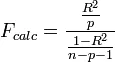
 rejet de H0 si et seulement si Fcalc > F1 - α(p, n - p - 1), où α est le risque de première espèce. autrement dit, si la p-value du test de fisher (probabilité critique du test) avec  est inférieure à α  , l'hypothèse nulle est rejetée.

**Prob(F-Statistic):  Ici, elle est très faible et inférieure au seuil alpha 5 % (ou 1 %), on rejet l'hypothèse nulle, notre modèle est significatif.**

***Significativité des coefficients: test de student***: 
Les probabilités des variables explicatives sont inférieure à 0.05 ces variables sont statistiquement significatives dans le modèle 

### tests sur la regression linéaire multiple

Conditions d’application


**Normalité de la distribution des résidus** :  l'hypothèse nulle est que les résidus sont distribués selon une loi Normale. La valeur de Prob(Omnibus) doit être proche de 1. Ici elle est nulle ce qui implique que l'hypothèse n'est pas verifée, les coefficiants estimés ne seront pas BLUE. Prob(Jacque-Bera) est redondant avec Prob(Omnibus), une valeur élevée pour le Jarque-Bera indique que les résidus sont distribués selon une loi Normale. Pour lever le doute on effectue un test d'Aderson-Darling qui nous indique que les résidus suivent une distribution Normale.

**Homocédasticité** : les variances des résidus doivent être constantes. Les tests de Breusch-Pagan et de White permettent de tester l'hypothèse d'homoscédasticité du terme d'erreur d'un modèle de régression linéaire. Le test de Breusch-Pagan ne fonctionne pas très bien pour les distributions non-normales et non-linéaires contrairement au test de White qui est en fait un cas particulier du Breusch-Pagan. Il existe aussi le test de Goldfeld et Quandt qui n'est plus vraiment utilisé.

**Non-autocorrélation** : l'autocorrélation est la corrélation des erreurs (résidus) dans le temps. Durbin-Watson < 1.5, autocorrélation positive, l'hypothèse n'est pas satisfaite. 1.5 < Durbin-Watson < 2.5 pas d'autocorrélation, l'hypothèse est satisfaite. Durbin-Watson > 2.5, autocorrélation négative, l'hypothèse n'est pas satisfaite. Ici, il est de 1.888, il n'y a donc pas d'autocorrélation.

**Multicollinéarité** : on suppose que les prédicteurs utilisés dans la régression ne sont pas corrélés les uns aux autres. Le cond. No. est élevée il semble qu'il y ai un problème de multicollinéarité. Le VIF indique effectivment une forte multicolinéarité.

**Linéarité** : on fait l'hypothèse qu'il existe une relation linéaire entre les variables indépendantes et la variable dépendante. Non verifée ici, les estimateurs ne seront pas BLUE (ils sont biaisés).




In [65]:

# La moyenne des residus est nulle:
reg_multi.resid.mean()

-6.909214599400673e-14

In [66]:
# multicolinéarité
vif= pd.Series([variance_inflation_factor(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].values, i)
               for i in range(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].shape[1])],
              index=Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

VIF par features:
 diagonal        170566.670778
height_left     111895.309916
height_right    100858.864433
margin_up          261.969190
length           22708.222743
dtype: float64
VIF moyen: 81258.20741161003


 forte multicolinéarité

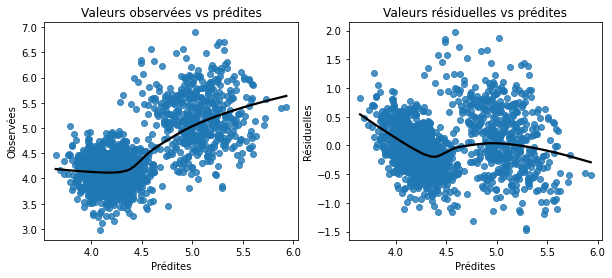

In [67]:
# Linearite:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel="Prédites", ylabel="Observées")

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel="Prédites", ylabel="Résiduelles")
    
linearity_test(reg_multi, Reg_Lin_Train_df["margin_low"])

La relation n'est pas linéaire, l'hypothèse de linéarité n'est pas vérifiée. Solutions potentielles :

Transformation non-linéaire sur les variables dépendantes/indépendantes.

Ajout d'une feature, transformation de features préexistantes (mise au carré par exemple).

Ajout de features non considérées précédemment.

<ipython-input-68-4ebb3a432885>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["margin_low_pred"] = reg_multi.predict(x_train)
<ipython-input-68-4ebb3a432885>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]


La p-value du test d'Aderson-Darling vaux 5.114137678791534e-12


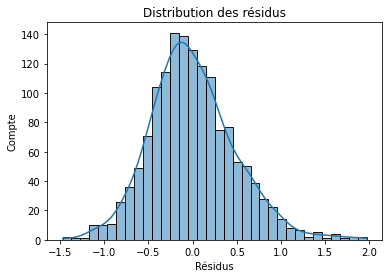

In [68]:
# Normalité des résidus
# Creation d'une colonne contenant les residus:
Reg_Lin_Train_df["margin_low_pred"] = reg_multi.predict(x_train)
Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]

# Normalite:
print("La p-value du test d'Aderson-Darling vaux", normal_ad(Reg_Lin_Train_df["residual"])[1])

# Graphique:
sns.histplot(Reg_Lin_Train_df["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

La p-value <0.05: les résidus suivent une loi normale

{'Test Statistic': 109.86015196911538, 'p-value': 2.0828244985829586e-14, 'F-Statistic': 5.853731207827404, 'F-Test p-value': 4.974865091682684e-15}


Text(0.5, 1.0, 'Homoscédasticité')

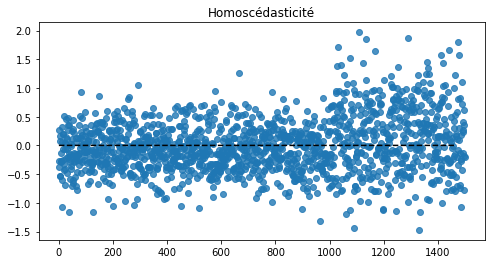

In [69]:
# Homoscedasticite:
white_test = het_white(reg_multi.resid, reg_multi.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=Reg_Lin_Train_df.index, y=Reg_Lin_Train_df["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(Reg_Lin_Train_df.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée au risque alpha 5 %

### Imputation des valeurs manquantes

Nous allons faire une prediction des valeurs manquantes sur la variable margin_low à partie des résultats de la regression linéaire

In [70]:
NA_data=billets[billets.isnull().any(axis=1)]
NA_data.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [71]:
na_data1=NA_data.drop(columns=['margin_low'], axis=1)
na_data1.head(5)

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,True,171.94,103.89,103.45,3.25,112.79
99,True,171.93,104.07,104.18,3.14,113.08
151,True,172.07,103.80,104.38,3.02,112.93
197,True,171.45,103.66,103.80,3.62,113.27
241,True,171.83,104.14,104.06,3.02,112.36


In [72]:
df_train=billets.dropna()
df_train

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [73]:
y_train=df_train['margin_low']
y_train

0       4.52
1       3.77
2       4.40
3       3.62
4       4.04
        ... 
1495    4.42
1496    5.27
1497    5.51
1498    5.17
1499    4.63
Name: margin_low, Length: 1463, dtype: float64

In [74]:
x_train=df_train.drop(columns=['is_genuine','margin_low'], axis=1)
x_train

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...
1495,171.75,104.38,104.17,3.09,111.28
1496,172.19,104.63,104.44,3.37,110.97
1497,171.80,104.01,104.12,3.36,111.95
1498,172.06,104.28,104.06,3.46,112.25


In [75]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

In [76]:
lr.fit(x_train, y_train)

LinearRegression()

In [77]:
x_test=NA_data.drop(columns=['is_genuine','margin_low'], axis=1)
x_test.head(5)

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


In [78]:
y_pred=lr.predict(x_test)
y_pred

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [79]:
na_data1['margin_low']=y_pred
na_data1

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.318525
99,True,171.93,104.07,104.18,3.14,113.08,4.393668
151,True,172.07,103.80,104.38,3.02,112.93,4.410457
197,True,171.45,103.66,103.80,3.62,113.27,4.319014
241,True,171.83,104.14,104.06,3.02,112.36,4.650617
251,True,171.80,103.26,102.82,2.95,113.22,3.803308
284,True,171.92,103.83,103.76,3.23,113.29,4.179736
334,True,171.85,103.70,103.96,3.00,113.36,4.127442
410,True,172.56,103.72,103.51,3.12,112.95,4.135034
413,True,172.30,103.66,103.50,3.16,112.95,4.160539


In [80]:
reg_result = [df_train, na_data1]
Billet_vf = pd.concat(reg_result)
Billet_vf

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.047570,2.93,111.21
1315,False,172.08,104.15,104.17,4.778967,3.40,112.29
1347,False,171.72,104.46,104.12,5.726993,3.61,110.31
1435,False,172.66,104.33,104.41,5.185862,3.56,111.47


In [81]:
Billet_vf.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Notre fichier n'a plus de valeurs manquantes

# Analyse  descriptive des billets

### Statistiques descriptives

In [82]:
Billet_vf.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


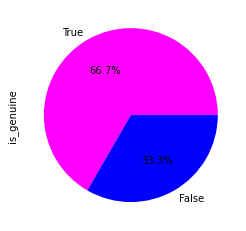

In [83]:
colors = ( "magenta", "blue")
Billet_vf["is_genuine"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors )


#### Distribution des billets en fonction de leur nature

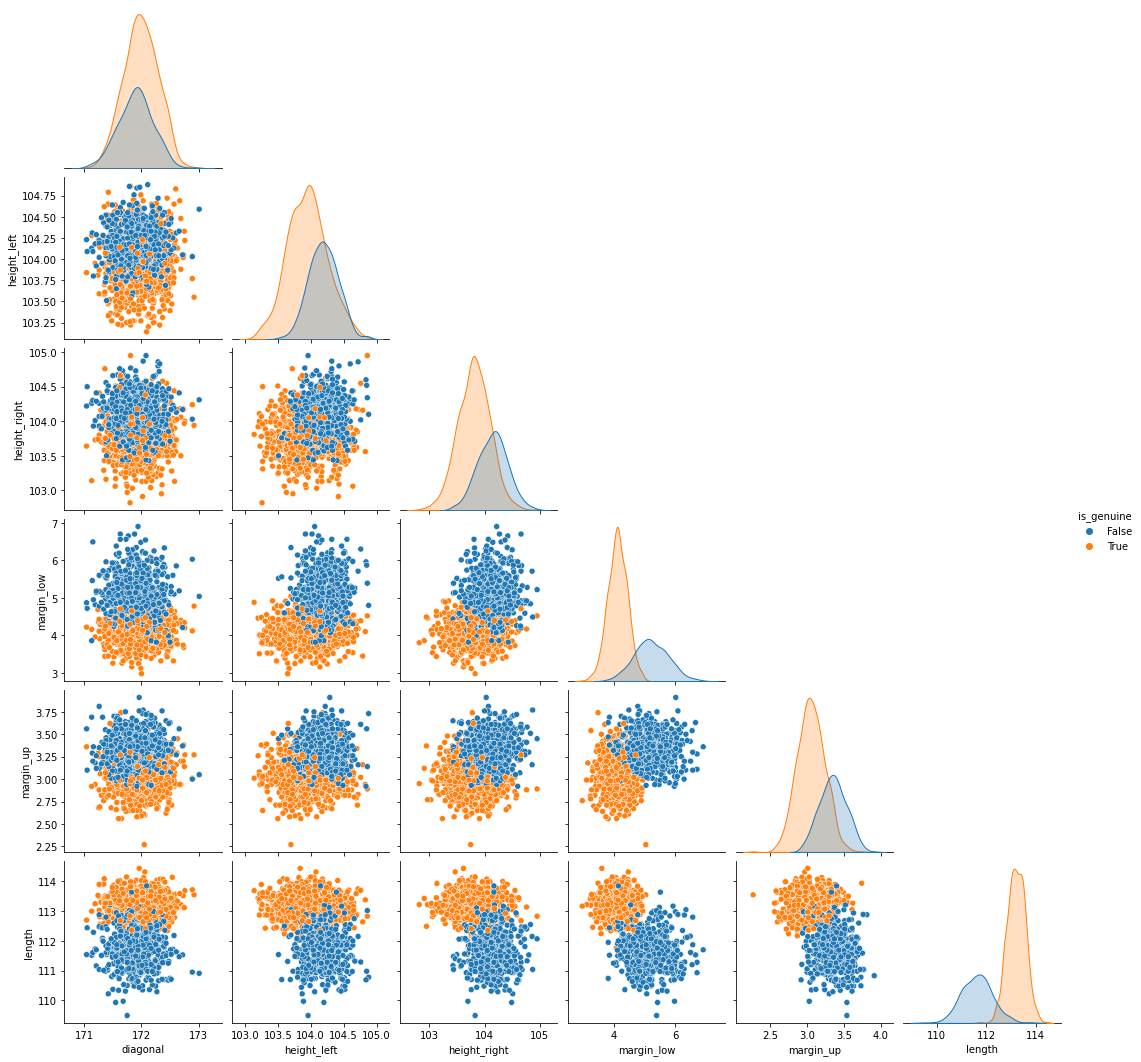

In [84]:
_ = sns.pairplot(Billet_vf, hue='is_genuine', corner=True)
_ = plt.show()

#### Distribution des billets

Diagonal


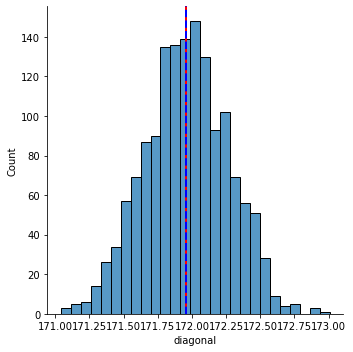

Skewness:  -0.03327338562609546
Kurtosis:  -0.12886436386674305
KstestResult(statistic=0.03966666666666667, pvalue=0.29623261897937836)
Height_left


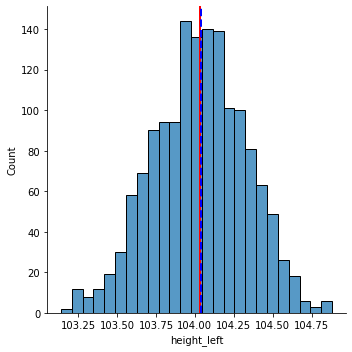

Skewness:  -0.0920284800066563
Kurtosis:  -0.19861842156870946
KstestResult(statistic=0.047, pvalue=0.13807640160436807)
Height_right


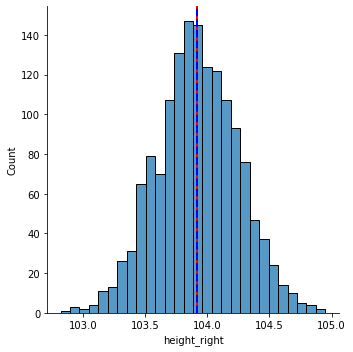

Skewness:  -0.00032721955634103526
Kurtosis:  -0.03113831813816237
KstestResult(statistic=0.02666666666666667, pvalue=0.7797723878003261)
Margin_low


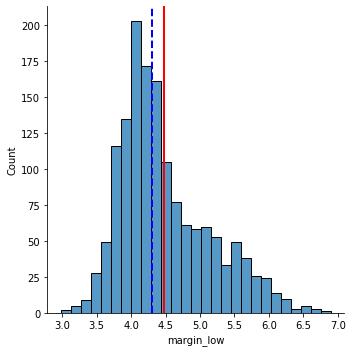

Skewness:  0.8697706246225988
Kurtosis:  0.24991754017065393
KstestResult(statistic=0.11266666666666666, pvalue=4.478268125218676e-07)
Margin_up


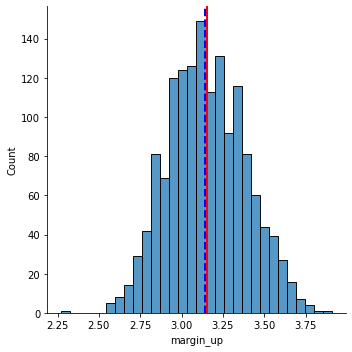

Skewness:  0.14579184782536242
Kurtosis:  -0.248256984444303
KstestResult(statistic=0.04666666666666667, pvalue=0.1433663848912069)
Length


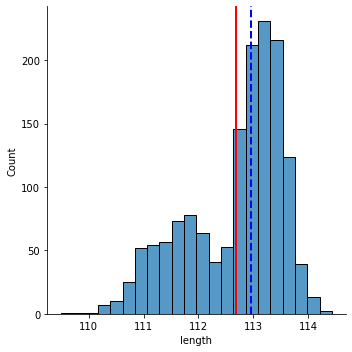

Skewness:  -0.8151403548537487
Kurtosis:  -0.2833883960922541
KstestResult(statistic=0.15833333333333333, pvalue=1.446620601086579e-13)


In [85]:
import scipy as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
def distrib_normalize(i):
  
  print(i.capitalize())
  _ = sns.displot(Billet_vf[i])
  _ = plt.axvline(x=Billet_vf[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
  _ = plt.axvline(x=Billet_vf[i].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
  _ = plt.show()
  print('Skewness: ', str(st.stats.skew(Billet_vf[i])))
  print('Kurtosis: ', str(st.stats.kurtosis(Billet_vf[i])))
  print(str(ks_2samp(Billet_vf[i],list(np.random.normal(np.mean(Billet_vf[i]), np.std(Billet_vf[i]), 1000)))))

cols = Billet_vf[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

for i in cols:
    distrib_normalize(i)

#### Matrice de correlation des variables

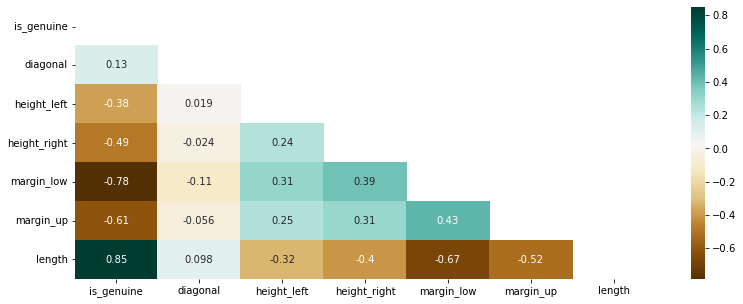

In [86]:
matrix = Billet_vf.corr()
# Triangle de corrélations
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(13, 5))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.show()

In [87]:
# séparation de notre dataset
faux_billets= Billet_vf.loc[Billet_vf['is_genuine'] ==False]
vrai_billets= Billet_vf.loc[Billet_vf['is_genuine'] ==True]
print(vrai_billets.shape,faux_billets.shape)


(1000, 7) (500, 7)


In [88]:
vrai_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.118174,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.317575,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.910000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.120000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [89]:
faux_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.214079,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.550363,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.180000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.590000,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


***Portrait-robot du vrai billet*** :

Hauteur mesurée à gauche : 103.95 mm

Hauteur mesurée à droite : 103.80 mm

Marge inférieure : 4.11 mm

Marge supérieure : 3.05mm

Longueur : 111.20 mm

Diagonale : 171.98 mm

***Portrait-robot du faux billet*** :

Hauteur mesurée à gauche : 103.94 mm

Hauteur mesurée à droite : 103.80 mm

Marge inférieure : 5.21 mm

Marge supérieure : 3.35mm

Longueur : 111.63 mm

Diagonale : 171.90 mm

### Test sur les billets

#### vérifions si les  différences de moyennes des caractéristiques de nos billets sont significatives
Test ANOVA

H0: Les moyennes des vrais billets et celles des faux billets sont égales

H1: Les moyennes ne sont pas égales.

In [90]:
import statsmodels
from statsmodels.stats.weightstats import ztest
import scipy
from scipy.stats import norm
from scipy.stats import skew, kurtosis

# Variable quantitative
x =( "diagonal","height_left","height_right","margin_low","margin_up","length")
# Variable qualitative
y = "is_genuine"
for i in x:
    samplei = Billet_vf[i][Billet_vf[y]]
    sample1 = Billet_vf[i][~Billet_vf[y]]

    FSTAT, pvalue = scipy.stats.f_oneway(samplei, sample1)
    print("FSTAT = {}, pvalue = {}".format(
        round(FSTAT, 2),
        round(pvalue, 2)))
    if pvalue < 0.05:
        print("On rejette H0.\nLes vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= {} à un niveau de confiance de 95%.".format(i))
       
    else:
        print("On ne rejette pas H0: Les moyennes sont identiques pour la variable x= {} à un niveau de confiance de 95%.".format(i))
    

FSTAT = 26.87, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= diagonal à un niveau de confiance de 95%.
FSTAT = 252.56, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= height_left à un niveau de confiance de 95%.
FSTAT = 460.97, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= height_right à un niveau de confiance de 95%.
FSTAT = 2380.72, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= margin_low à un niveau de confiance de 95%.
FSTAT = 870.58, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= margin_up à un niveau de confiance de 95%.
FSTAT = 3876.65, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x=

Les moyennes des variables explicatives sont statistiquement différentes selon la nature du billet(faux ou vrai)

# Algorithme de reconnaissance des faux billets

Le but de ce projet est construire des algorithmes capables de faire des classifications automatiques en vue de partitionner les données(billets de banque) en vrais ou faux billets. Pour ce faire, nous allons construire duex algorithmes: le premier basé sur la regression logistique et le second sur le kmean

## Régression logistique:

Le principe du modèle de la régression logistique est d'expliquer la survenance ou non d'un événementdans notre casfaux billet ou vrai billet  par le niveau de variables explicativesquantitatives (notées X). le but est de construire un algorithme de regression logistique qui permet de classifier les billets en vrai ou faux. Nous allons segmenter nos données en données d'entrainement et données de test puis nous évaluerons notre modèle sur les données de test.

Nous allons d'abord implementer la regression logistiques avec la librairie statmodel qui nous permet d'avoir unrésumé des performance de la regression ainsi que les principaux paramètres.

In [91]:
y_billet = Billet_vf["is_genuine"]
print(y_billet.value_counts())

True     1000
False     500
Name: is_genuine, dtype: int64


In [92]:
#Fichier de variables explicatives
x_billet=Billet_vf.drop(columns=['is_genuine'], axis=1)
# ajout d'une constance au model
x_billet = sm.tools.add_constant(x_billet)
x_billet.head(5)

,const,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [93]:
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score

# Regression logistique:
reg_log = Logit(endog=y_billet,exog=x_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.028228
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Sun, 15 May 2022   Pseudo R-squ.:                  0.9557
Time:                        23:01:53   Log-Likelihood:                -42.342
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -204.5582    241.768     -0.846      0.398    -678.415     269.299
diagonal         0.068

la p_value est <0.05 donc le modèle est significatif dans sa globalité. il y a des variables qui ne sont pas significatives dans le modèle(la diagonale, heigth_left), mais avec le R2 ajusté très elevé, nous pouvons les garder dans le modèle 

### Modèle excluant les variables non significatives

In [94]:
x2_billet=Billet_vf.drop(columns=['is_genuine','diagonal','height_left'], axis=1)
# Regression logistique:
reg_log2 = Logit(endog=y_billet,exog=x2_billet)

# Calculs:
res_log2 = reg_log2.fit()

# Resume des resultats:
print(res_log2.summary())

Optimization terminated successfully.
         Current function value: 0.030986
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1496
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 May 2022   Pseudo R-squ.:                  0.9513
Time:                        23:01:53   Log-Likelihood:                -46.478
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
height_right    -5.0148      0.680     -7.376      0.000      -6.347      -3.682
margin_low      -5.868

**En excluant les deux variables 'diagonal', 'height_left', les statistiques et paramètres du modèle ne s'améliorent pas significativement. On va les garder pour la suite**

## Développement du modèle et prédiction

In [95]:
#valeurs caractéristiques et valeur cible
x = Billet_vf [['diagonal','height_left','height_right','margin_low','margin_up','length']]
y = Billet_vf["is_genuine"]

In [96]:
# Séparation du dataseet en données d'entrainement et données de test
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, 
                                                    random_state=1) 
y_test.size

300

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
reg_logit = linear_model.LogisticRegression()    
reg_logit.fit(x_train, y_train)   
y_pred = reg_logit.predict(x_test) 
   
print("Logistic Regression model accuracy(in %):",  
metrics.accuracy_score(y_test, y_pred)*100) 

Logistic Regression model accuracy(in %): 98.33333333333333


### Evaluation du modèle de regression logistique

***La matrice de confusion*** est un résumé des résultats de prédiction pour un problème particulier de classification. Elle compare les données réelles pour une variable cible à celles prédites par un modèle.
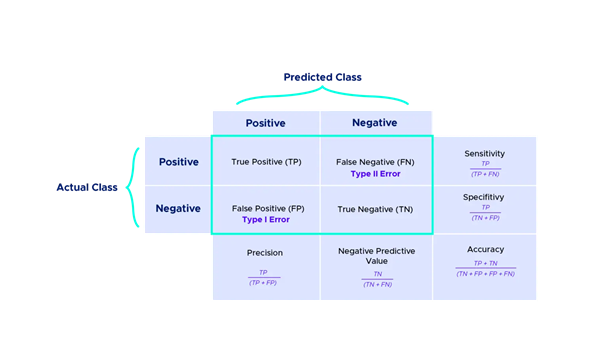

**Accuracy**: Performance globale du modèle, représente le taux de prédictions qui correspondent exactement aux étiquettes de classes réelles=TP+TN/(FP+FN+TP+TN)

**Precision**: la capacité d’un modèle à éviter d’étiqueter des échantillons négatifs comme positifs=TP/(TP+FP)

**Recall ou Sensibilité**: Couverture des observations vraiment positives=TP/TP+FN

**Spécificité**: Couverture des observations vraiment négatives=TN/TN+FP

F_score, courbe ROC et AUC.
 	
 	

In [98]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 92,   4],
       [  1, 203]], dtype=int64)

In [99]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test,  reg.predict(x_test))
conf

array([[ 92,   4],
       [  1, 203]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

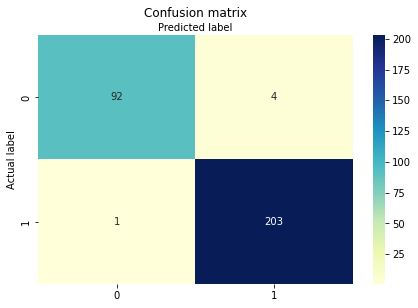

In [100]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
class_names=["Faux","Vrai"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))#xticklabels=["Faux","Vrai"], yticklabels=["Faux","Vrai"]
xticklabels =["Faux","Vrai"]#(tick_marks, class_names)
yticklabels=["Faux","Vrai"]#(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 1.0, 'Matrice de confusion de la régression logistique\n')

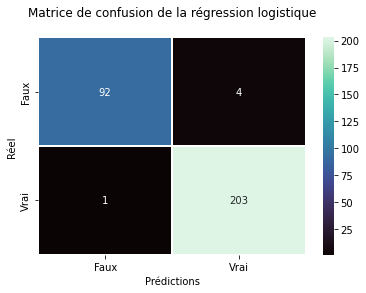

In [101]:
sns.heatmap(cnf_matrix,
            annot = True,
            fmt = ".3g", 
        
       cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion de la régression logistique\n")

In [102]:
y_test.value_counts()


True     204
False     96
Name: is_genuine, dtype: int64

In [103]:
from sklearn.metrics import precision_score, recall_score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
#print("Score F1:",F1_score(y_test, y_pred))

Accuracy: 0.9833333333333333
Precision: 0.9806763285024155
Recall: 0.9950980392156863


**Interpretation de la matrice de confusion**

La matrice de confusion nous donne des informations sur la performance de prediction du modèle.
Sur les 96 faux billets, 92 ont été correctement prédit(vrais négatifs) soit un taux de prediction de 95,83%.

les vrais positifs ou le nombre de vrais billets qui ont éte correctement classés est de 203 sur les 204 vrais billets de l'echantillon de test.
le nombre de faux positif ou le vrais billets de banque qui ont été classifiés comme faux est de 1
le nombre de faux négatifs ou les faux billets de banque qui ont été classés comme vrai par le modèle est de 4

**Interpretation des autres métriques**:

**L'accuracy est de 98%** c'est à dire que la capacité du modèle à faire de bonnes prédictions sur cet échantillon est de 98.3%;

**La précision est de 98,08%** c'est  la part des enregistrements réellement positifs(vrais billets) sur les enregistrements positifs prédits;

**Le Recall ou rappel est de 99,50%**: c'est la part des vrais billets correctement predits sur le nombre total de vrais billet ou Couverture des observations vraiment positives.

Les métriques d'évaluation de notre modèle de regression logistique sont satisfaisantes.


### Courbe ROC

La fonction d’efficacité du récepteur, plus fréquemment désignée sous le terme « courbe ROC», dite aussi caractéristique de performance (d'un test) ou courbe sensibilité/spécificité, est une mesure de la performance d'un classificateur binaire.
Graphiquement, on représente souvent la mesure ROC sous la forme d'une courbe qui donne le taux de vrais positifs en fonction du taux de faux positifs.
Un score AUC de 1 représente un classificateur parfait, un score de 0.5 représente un classificateur inutile.

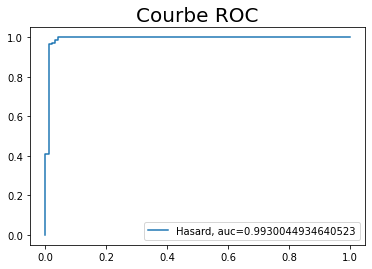

In [104]:
y_pred_proba = reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
x = [0,1]
y = [0,1]
plt.plot(fpr,tpr,label="Hasard, auc="+str(auc))
plt.legend(loc=4)
plt.title('Courbe ROC', fontsize=20)
ax.set_ylabel('Taux Vraix Positifs', fontsize=14)
ax.set_xlabel('Taux Faux Positifs', fontsize=14)
plt.show()

#### Application du modèle aux données test

In [105]:
clr = LogisticRegression()
clr.fit(x_train, y_train)

LogisticRegression()

In [106]:
essai= pd.read_csv("billets_production.csv", sep=',')
essai

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [107]:
X = essai.iloc[:, :-1]
X

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.76,104.01,103.54,5.21,3.30,111.42
1,171.87,104.17,104.13,6.00,3.31,112.09
2,172.00,104.58,104.29,4.99,3.39,111.57
3,172.49,104.55,104.34,4.44,3.03,113.20
4,171.65,103.63,103.56,3.77,3.16,113.33


In [108]:
#Utilisation du modèle de prédiction 'lr'
probability = reg_logit.predict_proba(X.values)[:, 1]

In [109]:
#Probabilités des billets établies 
proba = pd.Series(probability.round(3), name='value')
proba

0    0.003
1    0.001
2    0.001
3    0.922
4    1.000
Name: value, dtype: float64

In [110]:
df = pd.concat([essai, proba], axis=1)
df

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.003
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.001
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.001
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.922
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.000


Dataframe final avec résultats des classifications:\ Pour chaque billet, l'algorithme de classification donnera la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [111]:
#Résultats de la classification prédictive :
resultat = []
for i in df['value'] >= .5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

df['resultat'] = resultat
df

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value,resultat
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.003,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.001,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.001,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.922,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.000,Vrai Billet


In [112]:
for i, k in zip(df['value'],df["id"]):
    if i > 0.5:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


### Sauvegarde du modèle de regression logistique

In [113]:
import joblib
from joblib import dump, load
dump(reg_logit, 'logit_model_detection.joblib')

['logit_model_detection.joblib']

# k-means

**Le K-Means** est un algorithme simple d’apprentissage non supervisé utilisé pour résoudre les problèmes de clustering. Il suit une procédure simple consistant à classer un ensemble de données dans un nombre de clusters, défini par la lettre « k« , qui est fixé au préalable.On considère la distance d'un point à la moyenne des points de son cluster ; la fonction à minimiser est la somme des carrés de ces distances. il permet de regrouper des individus ou objets ayant les caractéristiques les plus proches au sein de K groupes. Ces groupes (clusters) sont constitués par itération successive de leur centre de gravité jusqu'à ce que les centres de gravité soient parfaitement équilibrés. C'est ce que l'on appelle la convergence de l'algorithme.

Dans ce projet, nous allons diviser nos données en deux groupes que nous allons analyser pour vpir s'ils correspondent à la nature **vraie** ou **fausse** du billet. Nous projecterons les groupes obtenus dans le premier plan factoriel obtenu par la méthode d'analyse en composantes principales.

**l'ACP** va nous permettre de reduire notre dimensionnalité en identifiant les liens entre variables et visualiser les résultats du K-means dans un espace à 2 dimensions

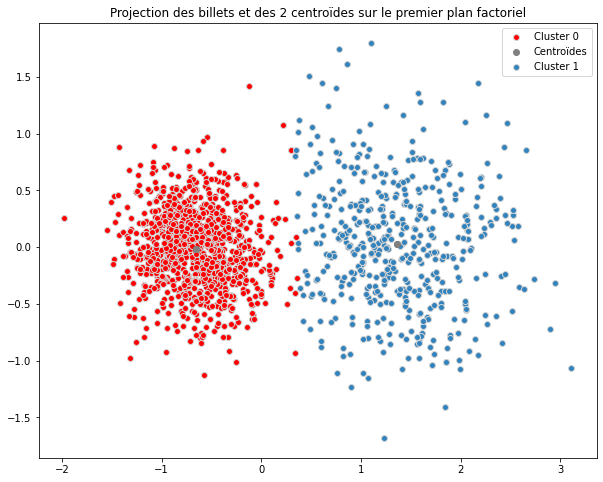

is_genuine  False  True 
row_0                   
0              19    997
1             481      3


In [114]:


# Options globales pour l'output display:
pd.options.display.float_format = "{:.3f}".format

# Nombre de clusters:
n_clust = 2

# Clustering par K-means:
km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(Billet_vf[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

# Ajout d'une colonne contenant le cluster attribue:
clusters_km = km.labels_
#Billet_df["cluster_km"] = km.labels_
#Billet_df["cluster_km"] = Billet_df["cluster_km"].apply(str)

centroids_km = km.cluster_centers_

# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=3).fit(Billet_vf[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(Billet_vf[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

# Graphique:
plt.figure(figsize=(10, 8))
colormap = np.array(['red', 'blue'])
for couleur,k in zip(['red', "#3182bd"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des billets et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()

#Verrfication de la classification: Matrice de confusion:
km_matrix = pd.crosstab(clusters_km,Billet_vf["is_genuine"])
print(km_matrix)



le cluster 1 semble être celui des faux billets et le cluster 0 celui des vrais billets

### Matrice de confusion du K-mean

In [115]:

tableau = pd.crosstab(clusters_km,Billet_vf["is_genuine"])
tableau.index = ['Cluster 0 - Vrai','Cluster 1 - Faux']
tableau.columns = ['Faux_billets','Vrai_billets']
tableau

,Faux_billets,Vrai_billets
Cluster 0 - Vrai,19,997
Cluster 1 - Faux,481,3


Text(0.5, 14.09375, 'Real label')

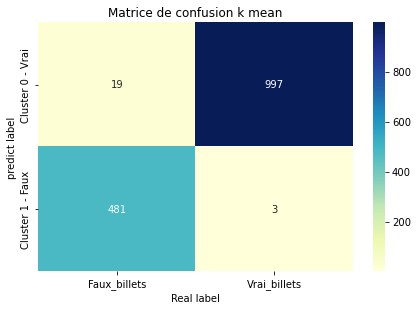

In [116]:
sns.heatmap(tableau, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrice de confusion k mean', y=1.1)
plt.ylabel('predict label')
plt.xlabel('Real label')

In [117]:
accuracy=round(((481+997)/1500)*100,2)
precision=round((997/(997+19))*100,2)
recall=round((997/(3+997))*100,2)
vrai_négatif=round((481/500)*100,2)
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("vrai négatif:",vrai_négatif)


Accuracy: 98.53
Precision: 98.13
Recall: 99.7
vrai négatif: 96.2


In [118]:
centroids = centroids_km
pd.DataFrame(centroids, columns=Billet_vf[["diagonal","height_left","height_right","margin_low","margin_up","length"]].columns)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.987,103.952,103.813,4.124,3.058,113.196
1,171.898,104.193,104.145,5.238,3.347,111.592


**Interpretation de la matrice de confusion du k mean**

La matrice de confusion nous donne des informations sur la performance de prediction du modèle. Sur les 500 faux billets, 481 ont été correctement prédit(vrais négatifs) soit un taux de prediction de96,2% pour les faux billets. les vrais positifs ou le nombre de vrais billets qui ont éte correctement classés est de 997 sur les 1000 vrais billets de l'echantillon de test. le nombre de faux positif ou les vrais billets de banque qui ont été classifiés comme faux est de 3, le nombre de faux négatifs ou les faux billets de banque qui ont été classés comme vrai par le modèle est de 19

Interpretation des autres métriques:

L'accuracy est de 98,5% c'est à dire que la capacité du modèle à faire de bonnes prédictions sur cet échantillon est de 98.5%;

La précision est de 98,13% c'est la part des enregistrements réellement positifs(vrais billets) sur les enregistrements positifs prédits;

Le Recall ou rappel est de 99,7%: c'est la part des vrais billets correctement predits sur le nombre total de vrais billet ou Couverture des observations vraiment positives. pour les faux billets il est de 95,83%.

Les métriques d'évaluation de notre modèle de k means sont satisfaisantes.

#### Prédiction de nos données d'exemple 

In [119]:
km.predict(X)
k_score=pd.Series(km.predict(X))
#k_score=km.predict(X).Transpose
km_predict_result= pd.concat([essai, k_score], axis=1)
km_predict_result

,diagonal,height_left,height_right,margin_low,margin_up,length,id,0
0,171.760,104.010,103.540,5.210,3.300,111.420,A_1,1
1,171.870,104.170,104.130,6.000,3.310,112.090,A_2,1
2,172.000,104.580,104.290,4.990,3.390,111.570,A_3,1
3,172.490,104.550,104.340,4.440,3.030,113.200,A_4,0
4,171.650,103.630,103.560,3.770,3.160,113.330,A_5,0


Nous avons les mêmes résultats sur cet échantillon qu'avec la regression logistique

### Sauvegarde du modèle de k mean

In [120]:
import joblib
from joblib import dump, load
dump(x_km , 'kmean_model_detection.joblib')

['kmean_model_detection.joblib']

# Algorithme de detection des faux billets

In [121]:
#Données de test ou fichier à évaluer
Billet_test_df = pd.read_csv("billets_test.csv")
x_test = Billet_test_df [['diagonal','height_left','height_right','margin_low','margin_up','length']]

#chargement du modèle                                                                 

logit_model = load('logit_model_detection.joblib')
  
y_pred = logit_model.predict(x_test) 

Billet_test_df["proba"] = logit_model.predict(x_test)
Billet_test_df["pred"] = (logit_model.predict(x_test) >= 0.5).astype(int)

# Affichage des resultats:
print("\nIndetification des billets:\n")
for i, k in zip(Billet_test_df["pred"],Billet_test_df["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")


Indetification des billets:

Le billet B_1 est vrai
Le billet B_2 est faux
Le billet B_3 est vrai
Le billet B_4 est faux
Le billet B_5 est faux


Text(16, 23, 'Fin de formation DA')

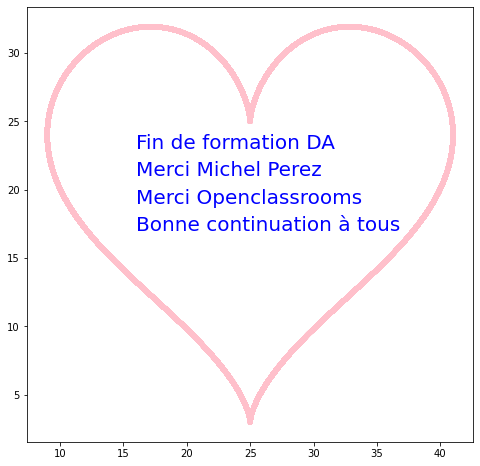

In [11]:
t= np.linspace(0,2200,100000)
x= 16*np.sin(t)**3+25 
y= 13*np.cos(t)-5*np.cos(2*t)-2*np.cos(3*t)-np.cos(4*t)+20
plt.figure(figsize=(8,8))
plt.plot(x,y,color="pink",linewidth=5)
plt.text(16,17, "Bonne continuation​ à tous", fontsize=20,color="blue")
plt.text(16,21, "Merci Michel Perez", fontsize=20,color="blue")
plt.text(16,19, "Merci Openclassrooms", fontsize=20,color="blue") 
plt.text(16,23,"Fin de formation DA", fontsize=20,color="blue")